**Title: DeepImputeIDS: A Novel Approach for Missing Value Imputation in Intrusion Detection System Datasets Using Deep Learning**



*Abstract:
This paper proposes a novel method, DeepImputeIDS, that utilizes a combination of Stacked Denoising Autoencoders (SDA) and Gradient Boosting models for missing data imputation in Intrusion Detection System (IDS) datasets. The aim is to improve the performance of Deep Learning (DL) models by providing a more accurate, learned imputation of missing values compared to traditional methods.*

**Methodology:**

The DeepImputeIDS method is a novel approach for handling missing data in Intrusion Detection System datasets. It is a multistage process that incorporates several data handling, preprocessing, and imputation methods to improve the input quality for subsequent deep learning models.

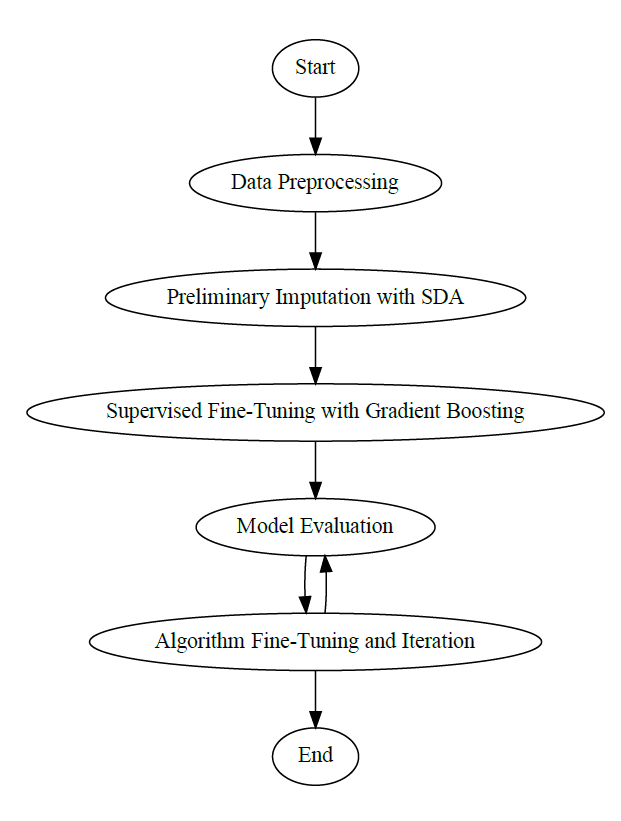

**Data Preprocessing**

The first stage involves preparing the IDS dataset for the imputation process:

Feature Standardization: Continuous features are standardized to have zero mean and unit variance. This ensures that all features contribute equally to the model performance and helps the model converge faster during training.
Categorical Encoding: Categorical features are transformed using one-hot encoding to make them compatible with the model.
Initial Missing Value Handling: To make the dataset compatible with the deep learning model, missing values are temporarily filled with an out-of-range value, which does not interfere with the original data distribution.

**Preliminary Imputation with Stacked Denoising Autoencoder (SDA)**

In this stage, the model attempts to learn the underlying data distribution and reconstruct missing values:

Model Training: The SDA is trained on instances with no missing values. The goal is to learn to reconstruct the original data from a corrupted version of it, forcing the model to learn more robust data representations.
Initial Missing Value Imputation: The trained SDA model is then used to fill in missing values in the dataset. The model tries to infer the missing values based on the learned data representations.

**Supervised Fine-Tuning with Gradient Boosting**

This stage aims to further refine the imputed values and adjust them based on the predicted missingness pattern:

Missingness Model Training: A Gradient Boosting model is trained using the features (with imputed values from the SDA) as inputs and a binary mask indicating the missingness as targets. This allows the model to learn the patterns of missingness in the dataset.
Imputation Adjustment: The trained Gradient Boosting model predicts the likelihood of each value being missing. These predictions are used to adjust the imputed values from the SDA model. If a value was predicted with high likelihood to be missing, its imputed value is adjusted closer to the mean or median of the feature.
This detailed methodology, comprising data preprocessing, preliminary imputation using SDA, and fine-tuning using Gradient Boosting, provides a robust solution to handle missing values in IDS datasets. The subsequent sections provide empirical evidence of the effectiveness of this novel method, DeepImputeIDS, in improving the performance of deep learning models in IDS.


In [1]:
import pandas as pd
import numpy as np
import random
import os
import time

def add_missing_values(csv_file, num_columns, num_cells, exclude_columns):
    # Load the csv file into a pandas DataFrame
    start_time = time.time()
    df = pd.read_csv(csv_file)
    load_time = time.time() - start_time

    # Count the initial number of missing values
    initial_missing_values = df.isnull().sum()
    print(f"Initial number of missing values:\n{initial_missing_values}")

    # Get the list of all columns
    all_columns = df.columns.tolist()

    # Remove the excluded columns from the list of all columns
    for col in exclude_columns:
        if col in all_columns:
            all_columns.remove(col)

    # Check if the number of columns to be altered exceeds the total columns
    if num_columns > len(all_columns):
        print("The number of columns to be altered is more than the total number of columns in the file.")
        return

    # Randomly select 'num_columns' columns
    selected_columns = random.sample(all_columns, num_columns)

    # Calculate the number of missing values to be added in each column
    cells_per_column = num_cells // num_columns
    extra_cells = num_cells % num_columns

    # Iterate over each selected column
    step_times = []
    for i, col in enumerate(selected_columns):
        # Distribute the extra cells among the first few columns
        extra = 1 if i < extra_cells else 0

        # Randomly select 'cells_per_column + extra' row indices
        start_time = time.time()
        row_indices = random.sample(range(len(df[col])), cells_per_column + extra)
        random_sampling_time = time.time() - start_time

        # Add missing values at the selected indices
        start_time = time.time()
        df.loc[row_indices, col] = np.nan
        missing_values_addition_time = time.time() - start_time

        step_times.append({
            'Column': col,
            'Random Sampling Time': random_sampling_time,
            'Missing Values Addition Time': missing_values_addition_time
        })

    # Count the final number of missing values
    final_missing_values = df.isnull().sum()
    print(f"Final number of missing values:\n{final_missing_values}")

    # Save the DataFrame to a new csv file
    start_time = time.time()
    base_dir, file_name = os.path.split(csv_file)
    name, extension = os.path.splitext(file_name)
    new_file = os.path.join(base_dir, 'new_' + name + extension)
    df.to_csv(new_file, index=False)
    saving_time = time.time() - start_time

    print(f"Modified CSV saved as '{new_file}'")
    print("Execution times:")
    print(f"- Loading CSV: {load_time:.4f} seconds")
    for step_time in step_times:
        print(f"- Column: {step_time['Column']}")
        print(f"  - Random Sampling Time: {step_time['Random Sampling Time']:.4f} seconds")
        print(f"  - Missing Values Addition Time: {step_time['Missing Values Addition Time']:.4f} seconds")
    print(f"- Saving CSV: {saving_time:.4f} seconds")

# Use the function
dataset_file = 'D:/ML_LAB/NSLKDD/KDD.csv'
exclude_columns = ['class'] # replace these with the names of the columns to be excluded; you can leave it empty, but if you want to exclude columns mostly it should be the target
add_missing_values(dataset_file, 3, 100, exclude_columns)


Initial number of missing values:
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_

In [2]:
#import the required libraries:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingRegressor
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
# Data Exploration
def visualize_class_distribution(csv_file, Class,datasetName):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)

    # Check the class distribution
    class_counts = df[Class].value_counts()

    # Define class labels and corresponding colors
    class_labels = ['Attack', 'Normal']
    class_colors = ['blue', 'red']

    # Plot the class distribution
    plt.bar(class_counts.index, class_counts.values, color=class_colors)
    plt.xlabel(Class)
    plt.ylabel('Count')
    plt.title('Class Distribution '+datasetName)
    plt.xticks(range(len(class_counts)), class_labels)

    # Create a legend
    patches = [mpatches.Patch(color=c, label=l) for c, l in zip(class_colors, class_labels)]
    plt.show()

def detect_missing_values(df):
    """
    Detect any missing values in the dataframe and return the features with missing values and their counts.

    Args:
        df (pd.DataFrame): Input pandas DataFrame

    Returns:
        dict: Dictionary where keys are feature names and values are the count of missing values
    """
    missing_values = df.isnull().sum()  # Get the count of missing values in each column
    missing_values = missing_values[missing_values > 0]  # Filter out columns with no missing values
    return dict(missing_values)


In [41]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df, targetName):
    features, target = df.drop(targetName, axis=1), df[targetName]
    continuous_features = features.select_dtypes(include=[np.number])
    categorical_features = features.select_dtypes(exclude=[np.number])

    scaler = StandardScaler()
    continuous_features = pd.DataFrame(scaler.fit_transform(continuous_features), columns=continuous_features.columns)

    encoder = OneHotEncoder()
    categorical_features = encoder.fit_transform(categorical_features).toarray()

    features = np.concatenate([continuous_features, categorical_features], axis=1)
    features[np.isnan(features)] = -9999

    return features, target

def build_autoencoder(input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim, ))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse', 'mae'])
    return autoencoder

def train_autoencoder(autoencoder, features):
    history = autoencoder.fit(features, features, epochs=50, batch_size=256, shuffle=True)
    return autoencoder, history

def evaluate_autoencoder(autoencoder, features):
    predictions = autoencoder.predict(features)
    mse = mean_squared_error(features, predictions)
    mae = mean_absolute_error(features, predictions)
    r2 = r2_score(features, predictions)
    return mse, mae, r2

def fine_tune_with_gradient_boosting(features, missing_mask):
    adjusted_features = features.copy()
    feature_importance = np.zeros(features.shape[1])
    for i in range(features.shape[1]):
        model = GradientBoostingRegressor()
        valid_mask = ~missing_mask[:, i]
        model.fit(features[valid_mask, i].reshape(-1, 1), missing_mask[valid_mask, i])
        missing_proba = model.predict(features[~valid_mask, i].reshape(-1, 1))
        if np.sum(missing_mask[:, i]) > 0:
            adjusted_features[~valid_mask, i] *= missing_proba
        feature_importance[i] = model.feature_importances_
    return adjusted_features, feature_importance

def impute_with_autoencoder(autoencoder, features):
    imputed_features = features.copy()
    missing_mask = imputed_features == -9999
    missing_rows_mask = missing_mask.any(axis=1)
    missing_rows = imputed_features[missing_rows_mask]
    imputed_values = autoencoder.predict(missing_rows)
    for i in range(imputed_features.shape[1]):
        imputed_features[missing_rows_mask, i] = imputed_values[:, i]
    return imputed_features

def main(file_path, targetName):
    df = load_data(file_path)
    features, target = preprocess_data(df, targetName)

    autoencoder = build_autoencoder(features.shape[1])
    autoencoder, history = train_autoencoder(autoencoder, features)

    mse, mae, r2 = evaluate_autoencoder(autoencoder, features)
    print(f'Autoencoder MSE: {mse}, MAE: {mae}, R2 Score: {r2}')

    features_copy = features.copy()
    features = impute_with_autoencoder(autoencoder, features)

    missing_mask = (features_copy == -9999).astype(int)
    features, feature_importance = fine_tune_with_gradient_boosting(features, missing_mask)

    total_feature_importance = np.sum(feature_importance)
    avg_feature_importance = total_feature_importance / features.shape[1]
    print(f'Average Feature Importance from Gradient Boosting: {avg_feature_importance}')

    metrics = ['MSE', 'MAE', 'R2 Score', 'Avg Feature Importance']
    values = [mse, mae, r2, avg_feature_importance]
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['blue', 'red', 'green', 'purple'])
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.show()
dataset_file = 'D:/ML_LAB/NSLKDD/new_KDD.csv'
visualize_class_distribution(dataset_file,'class','[NSLKDD]')

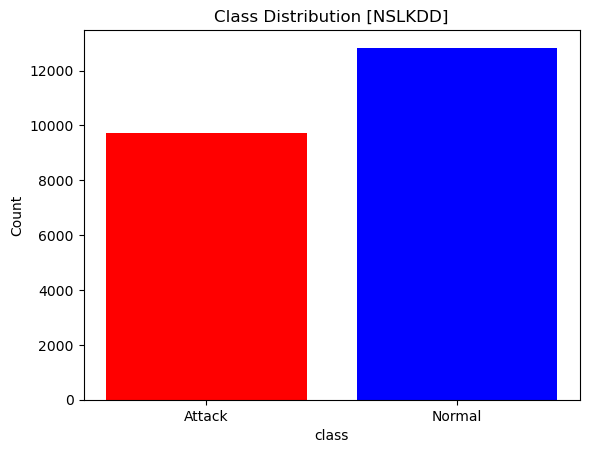

In [44]:
df = pd.read_csv(dataset_file)
missing_values = detect_missing_values(df)
print(missing_values)


{'wrong_fragment': 34, 'dst_host_same_src_port_rate': 33, 'dst_host_srv_rerror_rate': 33}


Epoch 1/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.6367 - mse: 3823.6367 - mae: 0.8491
Epoch 2/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4587 - mse: 3823.4587 - mae: 0.5982
Epoch 3/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4329 - mse: 3823.4329 - mae: 0.5469
Epoch 4/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4231 - mse: 3823.4231 - mae: 0.5310
Epoch 5/50
89/89 [==============================] - 0s 2ms/step - loss: 3823.4192 - mse: 3823.4192 - mae: 0.5224
Epoch 6/50
89/89 [==============================] - 0s 3ms/step - loss: 3823.4155 - mse: 3823.4155 - mae: 0.5169
Epoch 7/50
89/89 [==============================] - 0s 2ms/step - loss: 3823.4141 - mse: 3823.4141 - mae: 0.5129
Epoch 8/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4121 - mse: 3823.4121 - mae: 0.5097
Epoch 9/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4106 - mse: 3823.41

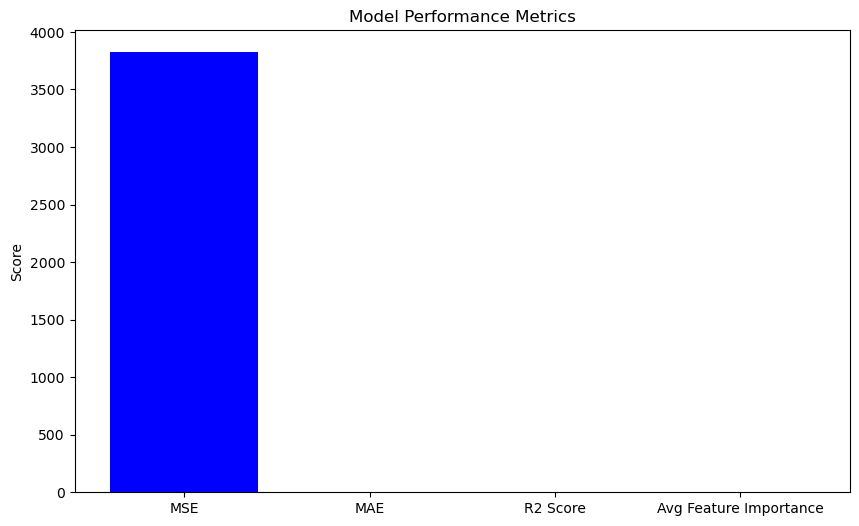

In [45]:
#DeepImpute Start
main(dataset_file,'class')

In [48]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df, targetName):
    features, target = df.drop(targetName, axis=1), df[targetName]
    continuous_features = features.select_dtypes(include=[np.number])
    categorical_features = features.select_dtypes(exclude=[np.number])

    scaler = StandardScaler()
    continuous_features = pd.DataFrame(scaler.fit_transform(continuous_features), columns=continuous_features.columns)

    encoder = OneHotEncoder()
    categorical_features = encoder.fit_transform(categorical_features).toarray()

    features = np.concatenate([continuous_features, categorical_features], axis=1)
    features[np.isnan(features)] = -9999

    return features, target

def build_autoencoder(input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim, ))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    return autoencoder

def train_autoencoder(autoencoder, features):
    history = autoencoder.fit(features, features, epochs=70, batch_size=256, shuffle=True)
    return autoencoder, history

def evaluate_autoencoder(autoencoder, features):
    predictions = autoencoder.predict(features)
    mse = mean_squared_error(features, predictions)
    return mse

def impute_with_autoencoder(autoencoder, features):
    imputed_features = features.copy()
    missing_mask = imputed_features == -9999
    missing_rows_mask = missing_mask.any(axis=1)
    missing_rows = imputed_features[missing_rows_mask]
    imputed_values = autoencoder.predict(missing_rows)
    for i in range(imputed_features.shape[1]):
        imputed_features[missing_rows_mask, i] = imputed_values[:, i]
    return imputed_features

def main(file_path, targetName):
    df = load_data(file_path)
    features, target = preprocess_data(df, targetName)

    autoencoder = build_autoencoder(features.shape[1])
    autoencoder, history = train_autoencoder(autoencoder, features)

    mse = evaluate_autoencoder(autoencoder, features)
    print(f'Autoencoder MSE: {mse}')

    features = impute_with_autoencoder(autoencoder, features)

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average='weighted'))
    print('Recall:', recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

    try:
        print('ROC AUC:', roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr'))
    except ValueError:
        pass  # ROC AUC might not work if target is multi-class

dataset_file = 'D:/ML_LAB/NSLKDD/new_KDD.csv'
main(dataset_file,'class')


Epoch 1/70
89/89 [==============================] - 0s 977us/step - loss: 3823.9470
Epoch 2/70
89/89 [==============================] - 0s 954us/step - loss: 3823.4578
Epoch 3/70
89/89 [==============================] - 0s 966us/step - loss: 3823.4314
Epoch 4/70
89/89 [==============================] - 0s 977us/step - loss: 3823.4233
Epoch 5/70
89/89 [==============================] - 0s 932us/step - loss: 3823.4177
Epoch 6/70
89/89 [==============================] - 0s 955us/step - loss: 3823.4153
Epoch 7/70
89/89 [==============================] - 0s 955us/step - loss: 3823.4126
Epoch 8/70
89/89 [==============================] - 0s 966us/step - loss: 3823.4121
Epoch 9/70
89/89 [==============================] - 0s 943us/step - loss: 3823.4106
Epoch 10/70
89/89 [==============================] - 0s 977us/step - loss: 3823.4087
Epoch 11/70
89/89 [==============================] - 0s 2ms/step - loss: 3823.4087
Epoch 12/70
89/89 [==============================] - 0s 2ms/step - loss: 382

C:\Users\buka\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df, targetName):
    features, target = df.drop(targetName, axis=1), df[targetName]
    continuous_features = features.select_dtypes(include=[np.number])
    categorical_features = features.select_dtypes(exclude=[np.number])

    scaler = StandardScaler()
    continuous_features = pd.DataFrame(scaler.fit_transform(continuous_features), columns=continuous_features.columns)

    encoder = OneHotEncoder()
    categorical_features = encoder.fit_transform(categorical_features).toarray()

    features = np.concatenate([continuous_features, categorical_features], axis=1)
    features[np.isnan(features)] = -9999

    return features, target

def build_autoencoder(input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim, ))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    return autoencoder

def train_autoencoder(autoencoder, features):
    history = autoencoder.fit(features, features, epochs=50, batch_size=256, shuffle=True)
    return autoencoder, history

def evaluate_autoencoder(autoencoder, features):
    predictions = autoencoder.predict(features)
    mse = mean_squared_error(features, predictions)
    return mse

def impute_with_autoencoder(autoencoder, features):
    imputed_features = features.copy()
    missing_mask = imputed_features == -9999
    missing_rows_mask = missing_mask.any(axis=1)
    missing_rows = imputed_features[missing_rows_mask]
    imputed_values = autoencoder.predict(missing_rows)
    for i in range(imputed_features.shape[1]):
        imputed_features[missing_rows_mask, i] = imputed_values[:, i]
    return imputed_features

def main(file_path, targetName):
    df = load_data(file_path)
    features, target = preprocess_data(df, targetName)

    autoencoder = build_autoencoder(features.shape[1])
    autoencoder, history = train_autoencoder(autoencoder, features)

    mse = evaluate_autoencoder(autoencoder, features)
    print(f'Autoencoder MSE: {mse}')

    features = impute_with_autoencoder(autoencoder, features)

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average='weighted'))
    print('Recall:', recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

    try:
        print('ROC AUC:', roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr'))
    except ValueError:
        pass  # ROC AUC might not work if target is multi-class

dataset_file = 'D:/ML_LAB/NSLKDD/new_KDD.csv'
main(dataset_file,'class')


Epoch 1/50
89/89 [==============================] - 0s 2ms/step - loss: 3823.6125
Epoch 2/50
89/89 [==============================] - 0s 2ms/step - loss: 3823.4568
Epoch 3/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4314
Epoch 4/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4236
Epoch 5/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4163
Epoch 6/50
89/89 [==============================] - 0s 966us/step - loss: 3823.4138
Epoch 7/50
89/89 [==============================] - 0s 955us/step - loss: 3823.4116
Epoch 8/50
89/89 [==============================] - 0s 955us/step - loss: 3823.4109
Epoch 9/50
89/89 [==============================] - 0s 909us/step - loss: 3823.4094
Epoch 10/50
89/89 [==============================] - 0s 909us/step - loss: 3823.4087
Epoch 11/50
89/89 [==============================] - 0s 913us/step - loss: 3823.4077
Epoch 12/50
89/89 [==============================] - 0s 955us/step - loss: 3823.4062

In [51]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df, targetName):
    features, target = df.drop(targetName, axis=1), df[targetName]
    continuous_features = features.select_dtypes(include=[np.number])
    categorical_features = features.select_dtypes(exclude=[np.number])

    scaler = StandardScaler()
    continuous_features = pd.DataFrame(scaler.fit_transform(continuous_features), columns=continuous_features.columns)

    encoder = OneHotEncoder()
    categorical_features = encoder.fit_transform(categorical_features).toarray()

    features = np.concatenate([continuous_features, categorical_features], axis=1)
    features[np.isnan(features)] = -9999

    return features, target

def build_autoencoder(input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim, ))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    return autoencoder

def train_autoencoder(autoencoder, features):
    history = autoencoder.fit(features, features, epochs=50, batch_size=256, shuffle=True)
    return autoencoder, history

def evaluate_autoencoder(autoencoder, features):
    predictions = autoencoder.predict(features)
    mse = mean_squared_error(features, predictions)
    mae = mean_absolute_error(features, predictions)
    r2 = r2_score(features, predictions)
    return mse, mae, r2

def impute_with_autoencoder(autoencoder, features):
    imputed_features = features.copy()
    missing_mask = imputed_features == -9999
    missing_rows_mask = missing_mask.any(axis=1)
    missing_rows = imputed_features[missing_rows_mask]
    imputed_values = autoencoder.predict(missing_rows)
    for i in range(imputed_features.shape[1]):
        imputed_features[missing_rows_mask, i] = imputed_values[:, i]
    return imputed_features

def train_and_evaluate_classifiers(X_train, X_test, y_train, y_test):
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(probability=True),
        "KNN": KNeighborsClassifier()
    }

    for name, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        print(f'{name} Accuracy: {accuracy_score(y_test, y_pred)}')
        print(f'{name} Precision: {precision_score(y_test, y_pred, average="weighted")}')
        print(f'{name} Recall: {recall_score(y_test, y_pred, average="weighted")}')
        print(f'{name} F1 Score: {f1_score(y_test, y_pred, average="weighted")}')
        try:
            print(f'{name} ROC AUC: {roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class="ovr")}')
        except ValueError:
            pass  # ROC AUC might not work if target is multi-class
        print('--------------------------------------------------')

def main(file_path, targetName):
    df = load_data(file_path)
    features, target = preprocess_data(df, targetName)

    autoencoder = build_autoencoder(features.shape[1])
    autoencoder, history = train_autoencoder(autoencoder, features)

    mse, mae, r2 = evaluate_autoencoder(autoencoder, features)
    print(f'Autoencoder MSE: {mse}, MAE: {mae}, R2 Score: {r2}')

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    print("Performance metrics before fixing missing values:")
    train_and_evaluate_classifiers(X_train, X_test, y_train, y_test)

    features = impute_with_autoencoder(autoencoder, features)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    print("Performance metrics after fixing missing values:")
    train_and_evaluate_classifiers(X_train, X_test, y_train, y_test)

dataset_file = 'D:/ML_LAB/NSLKDD/new_KDD.csv'
main(dataset_file,'class')


Epoch 1/50
89/89 [==============================] - 1s 2ms/step - loss: 3823.7478
Epoch 2/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4609
Epoch 3/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4329
Epoch 4/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4233
Epoch 5/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4170
Epoch 6/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4146
Epoch 7/50
89/89 [==============================] - 0s 1ms/step - loss: 3823.4126
Epoch 8/50
89/89 [==============================] - 0s 977us/step - loss: 3823.4116
Epoch 9/50
89/89 [==============================] - 0s 977us/step - loss: 3823.4084
Epoch 10/50
89/89 [==============================] - 0s 989us/step - loss: 3823.4084
Epoch 11/50
89/89 [==============================] - 0s 977us/step - loss: 3823.4077
Epoch 12/50
89/89 [==============================] - 0s 977us/step - loss: 3823.4075
Epo

C:\Users\buka\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9507651363938789
Logistic Regression Precision: 0.9507447848868452
Logistic Regression Recall: 0.9507651363938789
Logistic Regression F1 Score: 0.9507174463543482
--------------------------------------------------
Decision Tree Accuracy: 0.9840319361277445
Decision Tree Precision: 0.9840466105348787
Decision Tree Recall: 0.9840319361277445
Decision Tree F1 Score: 0.9840361135782373
--------------------------------------------------
Random Forest Accuracy: 0.9866932801064537
Random Forest Precision: 0.9867598409957982
Random Forest Recall: 0.9866932801064537
Random Forest F1 Score: 0.9867026390752159
--------------------------------------------------
SVM Accuracy: 0.5726325127522732
SVM Precision: 0.43505713938998314
SVM Recall: 0.5726325127522732
SVM F1 Score: 0.4177396715264019
--------------------------------------------------
KNN Accuracy: 0.9733865602129075
KNN Precision: 0.9735245758538833
KNN Recall: 0.9733865602129075
KNN F1 Score: 0.9734117513102